## Setting Up

In [6]:
#Installation of necessary packages 
#!pip install -r EEP153_Materials/Project2/requirements.txt
!pip install python-gnupg
!pip install eep153_tools
!pip install fooddatacentral
from eep153_tools.sheets import read_sheets
from  scipy.optimize import linprog as lp
import numpy as np
import warnings
import pandas as pd
import fooddatacentral as fdc
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Dietary Reference Intakes

#### `get_recommended_intake_from_cvs` takes as arguments the characteristics of a per (e.g., age, sex) and returns a pandas,.Series of Dietary Reference Intakes of our population interest.

In [7]:
def get_recommended_intake_from_csv(age, sex, csv_path):
    
    df = pd.read_csv(csv_path)
    if age <= 3:
        age_sex_cat = 'C 1-3'
    elif 4 <= age <= 8:
        age_sex_cat = f'{sex} 4-8'
    elif 9 <= age <= 13:
        age_sex_cat = f'{sex} 9-13'
    elif 14 <= age <= 18:
        age_sex_cat = f'{sex} 14-18'
    elif 19 <= age <= 30:
        age_sex_cat = f'{sex} 19-30'
    elif 31 <= age <= 50:
        age_sex_cat = f'{sex} 31-50'
    else:
        age_sex_cat = f'{sex} 51+'
    
    recommended_intake = df.set_index('Nutrition')[age_sex_cat]
    return recommended_intake

min_csv_path = './diet_min.csv'
max_csv_path = './diet_max.csv'
min_recommended_intake_series = get_recommended_intake_from_csv(25, 'M', min_csv_path)
max_recommended_intake_series = get_recommended_intake_from_csv(25, 'M', max_csv_path)

print("Min intake")
print(min_recommended_intake_series)
print()
print("Max intake")
print(max_recommended_intake_series)

Min intake
Nutrition
Energy                            2400.0
Protein                             56.0
Fiber, total dietary                33.6
Folate, DFE                        400.0
Calcium, Ca                       1000.0
Carbohydrate, by difference        130.0
Iron, Fe                             8.0
Magnesium, Mg                      400.0
Niacin                              16.0
Phosphorus, P                      700.0
Potassium, K                      4700.0
Riboflavin                           1.3
Thiamin                              1.2
Vitamin A, RAE                     900.0
Vitamin B-12                         2.4
Vitamin B-6                          1.3
Vitamin C, total ascorbic acid      90.0
Vitamin E (alpha-tocopherol)        15.0
Vitamin K (phylloquinone)          120.0
Zinc, Zn                            11.0
Name: M 19-30, dtype: float64

Max intake
Nutrition
Sodium, Na    2300
Energy        3100
Name: M 19-30, dtype: int64


## Import Food Price Data and Do data cleaning

In [8]:
from eep153_tools.sheets import read_sheets

food_price = read_sheets("https://docs.google.com/spreadsheets/d/1LGkbkm4NYZqV2Fubt8Px2PXVY_3tH1y2d6wIERyK0jk/edit?usp=sharing",sheet='price_information')

food_information = read_sheets("https://docs.google.com/spreadsheets/d/1LGkbkm4NYZqV2Fubt8Px2PXVY_3tH1y2d6wIERyK0jk/edit?usp=sharing",sheet='food_information')

food_price=food_price.set_index(["Reservation", "Tribe"])
food_information = food_information.set_index(["Food"])
food_price

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


Location  \
Reservation                      Tribe                                                            
Navajo Nation                    Navajo                                         Window Rock, AZ   
                                 Navajo                                          Scottsdale, AZ   
Uintah and Ouray Reservation     Ute                                          Fort Duchesne, UT   
                                 Ute                                                  Provo, UT   
Rosebud Indian Reservation       Rosebud Sioux                                      Mission, SD   
                                 Rosebud Sioux                                   Rapid City, SD   
Wind River Reservation           Eastern Shoshone; Northern Arapaho           Fort Washakie, WY   
                                 Eastern Shoshone; Northern Arapaho                  Casper, WY   
Cherokee Nation                  Cherokee - Eastern band                           Whittier, NC   
                                 Cherokee - Eastern band                              Sylva, NC   
                                 Cherokee                                         Tahlequah, OK   
                                 Cherokee                                             Tusla, OK   
Lake Traverse Indian Reservation Sisseton Wahpeton Oyate                           Sisseton, SD   
                                 Sisseton Wahpeton Oyate                          Watertown, SD   
Pine Ridge Reservation           Oglala Sioux                                    Pine Ridge, SD   
                                 Oglala Sioux                                     Watertown, SD   
Gila River Indian Reservation    Akimel O'odham (Pima) & Pee-Posh (Maricopa)        Phoenix, AZ   
                                 Akimel O'odham (Pima) & Pee-Posh (Maricopa)        Phoenix, AZ   
Blackfeet Indian Reservation     Blackfoot (Niitsitapi)                            Browning, MT   
                                 Blackfoot (Niitsitapi)                            Billings, MT   

                                                                                                  Grocery store  \
Reservation                      Tribe                                                                            
Navajo Nation                    Navajo                                                                 Bashas'   
                                 Navajo                                                                 Walmart   
Uintah and Ouray Reservation     Ute                                                      ute_plaza_supermarket   
                                 Ute                                                                    Walmart   
Rosebud Indian Reservation       Rosebud Sioux                                Turtle Creek Crossing Super Foods   
                                 Rosebud Sioux                                                          Walmart   
Wind River Reservation           Eastern Shoshone; Northern Arapaho                                     Smith's   
                                 Eastern Shoshone; Northern Arapaho                                     Walmart   
Cherokee Nation                  Cherokee - Eastern band                                              Food Lion   
                                 Cherokee - Eastern band                                               Walmart    
                                 Cherokee                                                              Reasor's   
                                 Cherokee                                                              Walmart    
Lake Traverse Indian Reservation Sisseton Wahpeton Oyate                                            Buche Foods   
                                 Sisseton Wahpeton Oyate                                               Walmart    
Pine Ridge Reservation           Oglala Sioux                       

In [9]:
food_information['reservation_ave_price'] = np.mean(food_price[food_price['Grocery store']!='Walmart'].iloc[:,2:16], axis=0)
food_information['walmart_ave_price'] = np.mean(food_price[food_price['Grocery store']=='Walmart'].iloc[:,2:16], axis=0)
food_information

,Quantity,Unit,FDC,reservation_ave_price,walmart_ave_price
Food,,,,,
Apple,1.0,pound,454004,1.362857,1.328333
Egg,12.0,xl_egg,1663044,3.377143,2.856667
Ground beef,1.0,pound,1942314,4.885000,4.608333
Loaf of white bread,1.0,pound,2071641,2.441429,1.420000
Whole Milk,1.0,gallon,2340762,3.388571,2.696667
Tomato,1.0,pound,2345232,1.524286,1.696667
Whole Chicken,1.0,pound,2683347,2.468462,1.436667
Carrots,1.0,pound,2345173,1.253571,1.313333
Spaghetti,16.0,oz,2099117,1.445000,0.980000


## Helpful Data Analysis Plots

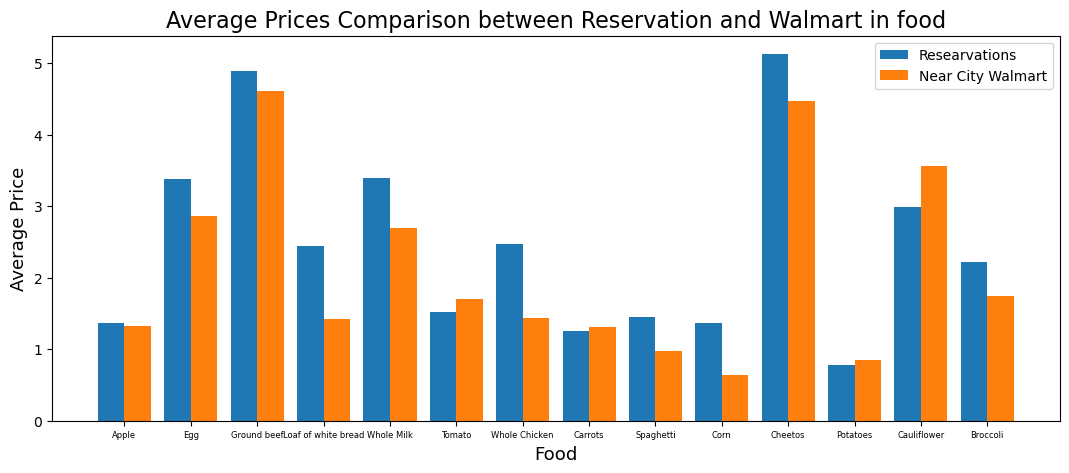

In [10]:
plt.figure(figsize=(13,5))
X = food_information.index 
Y_reservation_average_price = food_information['reservation_ave_price']
Z_walmart_ave_price = food_information['walmart_ave_price']
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, Y_reservation_average_price, 0.4, label = 'Researvations') 
plt.bar(X_axis + 0.2, Z_walmart_ave_price, 0.4, label = 'Near City Walmart') 
  
plt.xticks(X_axis, X, fontsize=6) 
plt.xlabel("Food", fontsize=13) 
plt.ylabel("Average Price", fontsize=13) 
plt.title("Average Prices Comparison between Reservation and Walmart in food",fontsize=16) 
plt.legend() 
plt.show() 

## Minimum Subsistance Food Cost

In [11]:
apikey = "PYsA9PuIqBESOYtWIQtsYmRj1wHxQd52DHjDr0Hl"

In [12]:
%pip install -r requirements.txt --upgrade

  Using cached Pint-0.23-py3-none-any.whl (305 kB)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached pandas-2.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached scipy-1.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.5 MB)
  Using cached gspread-6.0.2-py3-none-any.whl (53 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
  Using cached Bottleneck-1.3.8-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (353 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached StrEnum-0.4.15-py3-none-any.whl (8.9 kB)
  Using cached gspread-5.12.4-py3-none-any.whl (49 kB)
  Attempting uninstall: Pint
    Found existing installation: Pint 0.17
    Uninstalling Pint-0.17:
      Successfully uninstalled Pint-0.17
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling nump

In [13]:
import fooddatacentral as fdc

## Define `solve_subsistence_problem`  function

In [14]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to nutrients, columns to food.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='highs')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

### Units & Price

In [15]:
food_information['FDC Quantity'] = food_information[['Quantity','Unit']].T.apply(lambda x : fdc.units(x['Quantity'],x['Unit']))

# Now divide price by the FDC Quantity to get, e.g., price per hectoliter
food_information['FDC_reservation_ave_price'] = food_information['reservation_ave_price']/food_information['FDC Quantity']
food_information['FDC_walmart_ave_price']=food_information['walmart_ave_price']/food_information['FDC Quantity']
food_information.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Reservation_Prices = food_information.groupby('Food')['FDC_reservation_ave_price'].min()
Near_city_walmart_price=food_information.groupby('Food')['FDC_walmart_ave_price'].min()
Reservation_Prices

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


Food
Apple                  0.30045856874910454 / hectogram
Broccoli               0.48958369509484595 / hectogram
Carrots                0.27636519295318573 / hectogram
Cauliflower             0.6594971100216195 / hectogram
Cheetos                  2.126972022353432 / hectogram
Corn                    0.3214969674833186 / hectogram
Egg                     0.5025510204081632 / hectogram
Ground beef             1.0769581507731265 / hectogram
Loaf of white bread     0.5382428658199367 / hectogram
Potatoes               0.17211803754862226 / hectogram
Spaghetti              0.31856796885714805 / hectogram
Tomato                 0.33604747678752056 / hectogram
Whole Chicken            0.544202614885594 / hectogram
Whole Milk             0.08951658688478975 / deciliter
Name: FDC_reservation_ave_price, dtype: object

### Map Nutritions

In [16]:
import warnings

D = {}
count = 0
for food in  food_information.index:
    try:
        FDC = food_information.loc[food_information.index==food,:].FDC.values[0]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC} for food {food}.")

FoodNutrients= pd.DataFrame(D,dtype=float)
FoodNutrients

Apple
Egg
Ground beef
Loaf of white bread
Whole Milk
Tomato
Whole Chicken
Carrots
Spaghetti
Corn
Cheetos
Potatoes
Cauliflower
Broccoli


,Apple,Egg,Ground beef,Loaf of white bread,Whole Milk,Tomato,Whole Chicken,Carrots,Spaghetti,Corn,Cheetos,Potatoes,Cauliflower,Broccoli
"Alcohol, ethyl",NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.61,NaN,NaN
Caffeine,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
"Calcium, Ca",0.00,63.00,18.0,0.00,123.00,10.00,NaN,33.00,0.00,3.00,56.00,30.00,0.00,47.00
"Carbohydrate, by difference",14.29,0.00,0.0,42.22,4.63,4.04,0.0,9.58,76.79,13.90,53.50,12.44,2.35,4.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vitamin E, added",NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
Vitamin K (phylloquinone),NaN,NaN,NaN,NaN,0.30,7.50,NaN,13.20,NaN,3.20,1.30,NaN,NaN,NaN
Vitamins and Other Components,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
Water,NaN,NaN,NaN,NaN,88.10,94.40,NaN,88.30,NaN,79.00,1.57,83.29,NaN,NaN


### Dietary Requirements

In [17]:
from eep153_tools.sheets import read_sheets

DRI_url = "https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['diet_minimums'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['diet_maximums'].set_index('Nutrition')

Key available for students@eep153.iam.gserviceaccount.com.


### Gender Age Groups Our Group Chose

In [18]:
groups=['F 4-8','M 4-8', 'F 31-50', 'M 31-50', 'F 51+', 'M 51+']

## Using `solve_subsistence_problem` to analyze Reservation Population Diet

In [19]:
cost=[]
for group in groups:
    tol = 1e-6

    result = solve_subsistence_problem(FoodNutrients, Reservation_Prices,diet_min[group],diet_max[group],tol=tol)
    cost+=[result.fun]
    print("\nCost of diet for %s is $%4.2f per day." % (group,result.fun))
    
    # Put back into nice series
    diet = result.diet

    print("Diet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("With the following nutritional outcomes of interest:")
    print(tab)
    print()

d={'Group': groups, 'Minimum Cost': cost}

reservation=pd.DataFrame(data=d)
    


Cost of diet for F 4-8 is $3.63 per day.
Diet (in 100s of grams or milliliters):
Carrots       10.237743
Potatoes       2.138481
Whole Milk     4.861789
dtype: float64

With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          1235.967384          1200.0
Protein                           30.915047            19.0
Fiber, total dietary              34.011883            16.8
Folate, DFE                      230.871291           200.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      147.190362           130.0
Iron, Fe                          10.000000            10.0
Magnesium, Mg                    230.379441           130.0
Niacin                            12.783240             8.0
Phosphorus, P                    930.623971           500.0
Potassium, K                    4888.538674          3800

## Using `solve_subsistence_problem` to analyze Near City Walmart Population Diet

In [20]:
cost=[]
for group in groups:
    tol = 1e-6

    result = solve_subsistence_problem(FoodNutrients, Near_city_walmart_price,diet_min[group],diet_max[group],tol=tol)
    cost+=[result.fun]
    print("\nCost of diet for %s is $%4.2f per day." % (group,result.fun))
    
    # Put back into nice series
    diet = result.diet

    print("Diet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("With the following nutritional outcomes of interest:")
    print(tab)
    print()

d={'Group': groups, 'Minimum Cost': cost}

nearcity=pd.DataFrame(data=d)
    


Cost of diet for F 4-8 is $3.13 per day.
Diet (in 100s of grams or milliliters):
Carrots       4.441871
Corn          6.706131
Potatoes      2.116291
Whole Milk    6.258627
dtype: float64

With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          1688.409660          1200.0
Protein                           44.923130            19.0
Fiber, total dietary              30.469617            16.8
Folate, DFE                      361.793233           200.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      191.072457           130.0
Iron, Fe                          10.000000            10.0
Magnesium, Mg                    264.260383           130.0
Niacin                            13.754828             8.0
Phosphorus, P                   1169.781795           500.0
Potassium, K                    4092.

### Analysis Plot

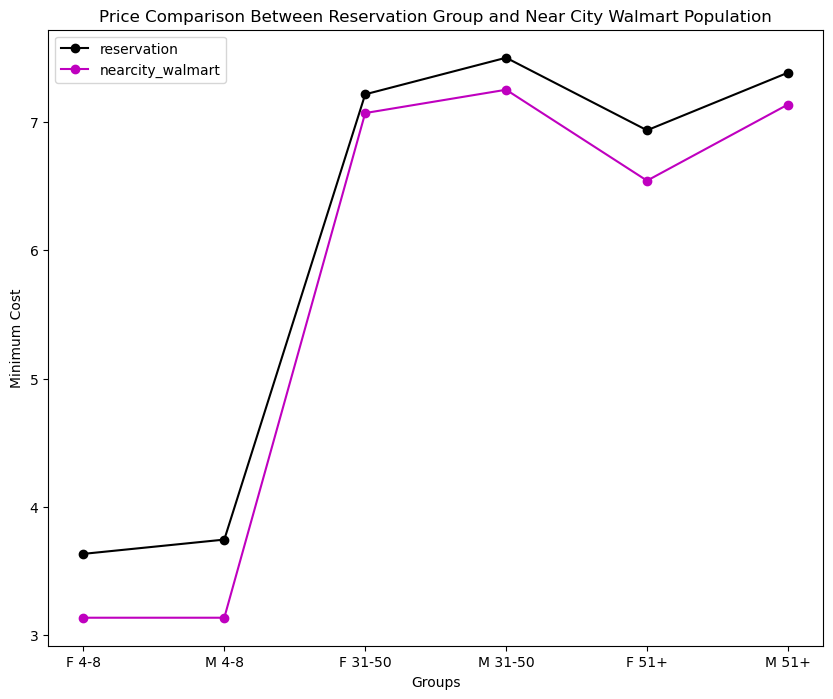

In [21]:
plt.figure(figsize=(10, 8))


line1 = plt.plot(groups, reservation["Minimum Cost"],'ko-',label='reservation')

line2 = plt.plot(groups, nearcity["Minimum Cost"],'mo-',label='nearcity_walmart')


# Adding legends, titles and labels
plt.legend()
plt.title('Price Comparison Between Reservation Group and Near City Walmart Population')
plt.xlabel('Groups')
plt.ylabel('Minimum Cost')

# Display the plot
plt.show()


In [22]:
cost_difference=reservation.merge(nearcity, on="Group")
cost_difference['difference']=cost_difference['Minimum Cost_x']-cost_difference['Minimum Cost_y']

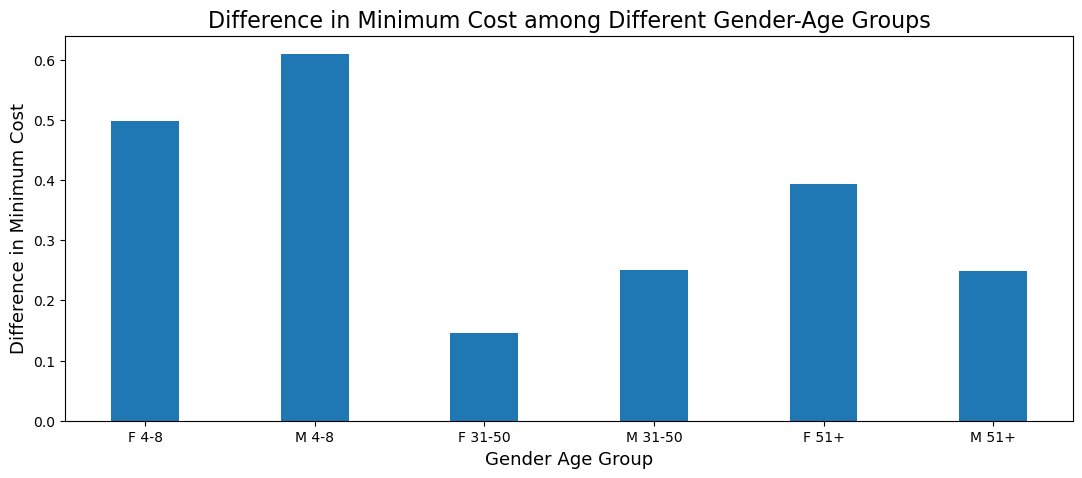

In [23]:
plt.figure(figsize=(13,5))
X = cost_difference['Group']
Y = cost_difference['difference']
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, Y , 0.4) 
  
plt.xticks(X_axis, X, fontsize=10) 
plt.xlabel("Gender Age Group", fontsize=13) 
plt.ylabel("Difference in Minimum Cost", fontsize=13) 
plt.title("Difference in Minimum Cost among Different Gender-Age Groups",fontsize=16) 
plt.show() 

## Sensitivity Analysis

#### The following function takes old_price series, the food chose to increase its price, and the price increaing rate, returns the new price series.

In [24]:
def price_increase(old_price, food, rate):
    new = old_price.copy()
    new[food] = old_price[food]*(1+rate)
    return new

If the price of whole milk increased by 10%, the following results show the the change in minimum subsistence food cost of the each group and its diet composition.

In [25]:
New_reservation_price = price_increase(Reservation_Prices, 'Whole Milk', 0.1)
New_nearcity_price=price_increase(Near_city_walmart_price, 'Whole Milk', 0.1)

### Reservation Population Minimum Subsistence Diet Cost after milk price change

In [28]:
cost=[]
for group in groups:
    tol = 1e-6

    result = solve_subsistence_problem(FoodNutrients,New_reservation_price,diet_min[group],diet_max[group],tol=tol)
    cost+=[result.fun]
    print("\nCost of diet for %s is $%4.2f per day." % (group,result.fun))
    
    # Put back into nice series
    diet = result.diet

    print("Diet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("With the following nutritional outcomes of interest:")
    print(tab)
    print()

d={'Group': groups, 'Minimum Cost': cost}

New_reservation=pd.DataFrame(data=d)
    


Cost of diet for F 4-8 is $3.68 per day.
Diet (in 100s of grams or milliliters):
Carrots       10.237743
Potatoes       2.138481
Whole Milk     4.861789
dtype: float64

With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          1235.967384          1200.0
Protein                           30.915047            19.0
Fiber, total dietary              34.011883            16.8
Folate, DFE                      230.871291           200.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      147.190362           130.0
Iron, Fe                          10.000000            10.0
Magnesium, Mg                    230.379441           130.0
Niacin                            12.783240             8.0
Phosphorus, P                    930.623971           500.0
Potassium, K                    4888.538674          3800

### Near-City Population Minimum Subsistence Diet Cost after milk price change

In [29]:
cost=[]
for group in groups:
    tol = 1e-6

    result = solve_subsistence_problem(FoodNutrients,New_nearcity_price,diet_min[group],diet_max[group],tol=tol)
    cost+=[result.fun]
    print("\nCost of diet for %s is $%4.2f per day." % (group,result.fun))
    
    # Put back into nice series
    diet = result.diet

    print("Diet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("With the following nutritional outcomes of interest:")
    print(tab)
    print()

d={'Group': groups, 'Minimum Cost': cost}

New_nearcity=pd.DataFrame(data=d)
    


Cost of diet for F 4-8 is $3.18 per day.
Diet (in 100s of grams or milliliters):
Carrots       4.441871
Corn          6.706131
Potatoes      2.116291
Whole Milk    6.258627
dtype: float64

With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          1688.409660          1200.0
Protein                           44.923130            19.0
Fiber, total dietary              30.469617            16.8
Folate, DFE                      361.793233           200.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      191.072457           130.0
Iron, Fe                          10.000000            10.0
Magnesium, Mg                    264.260383           130.0
Niacin                            13.754828             8.0
Phosphorus, P                   1169.781795           500.0
Potassium, K                    4092.

### Analysis Plot

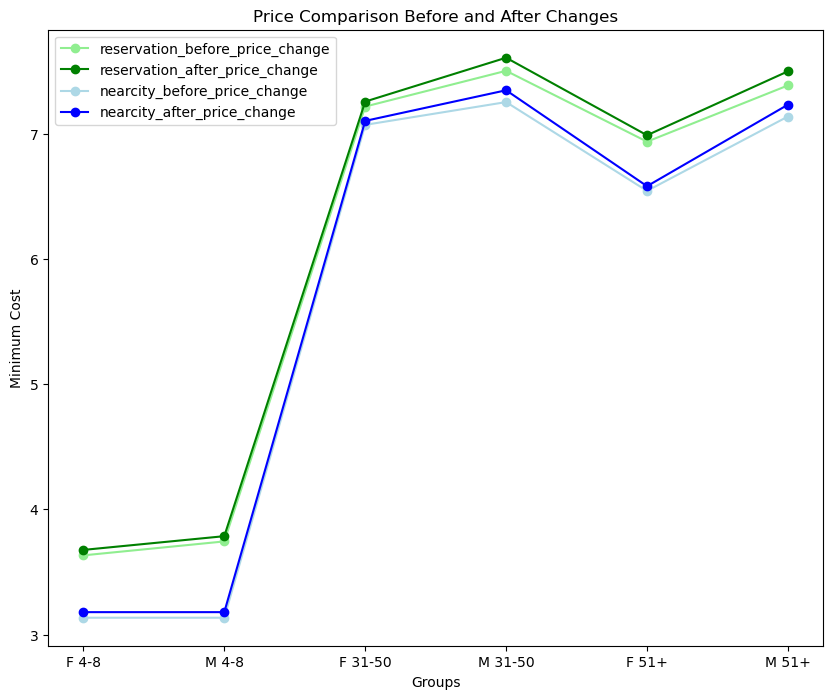

In [40]:
plt.figure(figsize=(10, 8))


line1 = plt.plot(groups, reservation["Minimum Cost"],'o-', color='lightgreen', label='reservation_before_price_change')
line2 = plt.plot(groups, New_reservation["Minimum Cost"],'go-',label='reservation_after_price_change') 
line3 = plt.plot(groups, nearcity["Minimum Cost"],'o-', color='lightblue',label='nearcity_before_price_change')
line4 = plt.plot(groups, New_nearcity["Minimum Cost"],'bo-',label='nearcity_after_price_change')

# Adding legends, titles and labels
plt.legend()
plt.title('Price Comparison Before and After Changes')
plt.xlabel('Groups')
plt.ylabel('Minimum Cost')

# Display the plot
plt.show()
